In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


In [3]:
data.info

<bound method DataFrame.info of         EngineVersion  AppVersion  AvSigVersion  RtpStateBitfield  \
0            0.552153    0.530941      0.587952               7.0   
1            0.448751    0.528931      0.484434               7.0   
2            0.552153    0.530941      0.557522               7.0   
3            0.552153    0.530941      0.482759               7.0   
4            0.493175    0.530941      0.505721               7.0   
...               ...         ...           ...               ...   
119947       0.552153    0.666667      0.531401               7.0   
119948       0.552153    0.530941      0.542553               7.0   
119949       0.448751    0.420644      0.484434               7.0   
119950       0.493175    0.530941      0.537931               7.0   
119951       0.552153    0.530941      0.539841               7.0   

        IsSxsPassiveMode  AVProductStatesIdentifier  AVProductsInstalled  \
0                      0                    53447.0            

Разобьем выборку на тест и трейн

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here




In [6]:
pipe_lr = Pipeline([('scaler', MinMaxScaler()),('LogReg', LogisticRegression())])
pipe_svm = Pipeline([('scaler', MinMaxScaler()),('LogReg', LinearSVC())])

In [7]:
### Обучаем модели на трейне
### Your code is here
pipe_lr.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)


Pipeline(steps=[('scaler', MinMaxScaler()), ('LogReg', LinearSVC())])

In [8]:
lg_pred = pipe_lr.predict(X_test)
svm_pred = pipe_svm.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score

In [13]:
print(round(accuracy_score(y_test, lg_pred),3),
      round(accuracy_score(y_test, svm_pred),3) )

0.843 0.84


Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import auc

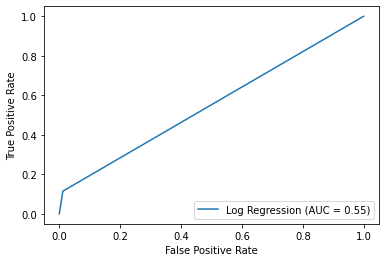

In [14]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here
# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
fpr_lg, tpr_lg, thresholds = roc_curve(y_test,lg_pred)
roc_auc_lg = auc(fpr_lg, tpr_lg)
RocCurveDisplay(fpr=fpr_lg, tpr=tpr_lg, roc_auc=roc_auc_lg, estimator_name='Log Regression').plot()
plt.show()

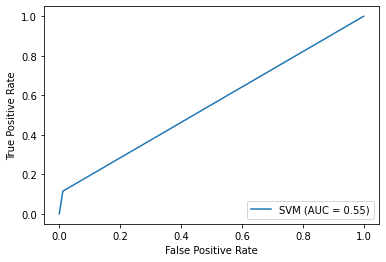

In [17]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here



fpr_svm, tpr_svm, thresholds = roc_curve(y_test,lg_pred)
roc_auc_svm = auc(fpr_svm, tpr_svm)
RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm, roc_auc=roc_auc_svm, estimator_name='SVM').plot()

plt.show()

In [18]:
print(roc_auc_lg, roc_auc_svm)

0.5517077396483795 0.5517077396483795


In [3]:
from sklearn.metrics import auc 

### Your code is here




Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

In [21]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay

### Your code is here


In [28]:
# svm_prob_pred = svm_pred = pipe_svm.predict_proba(X_test)
lg_pob_pred = pipe_lr.predict_proba(X_test)

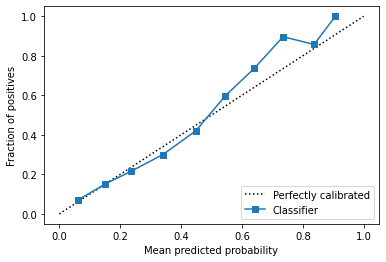

In [37]:
prob_true, prob_pred = calibration_curve(y_test, lg_pob_pred[:,1])
CalibrationDisplay.from_predictions(y_test, lg_pob_pred[:,1], n_bins=10)

In [38]:
svm_pob_pred = pipe_svm.decision_function(X_test)

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$

In [54]:
def colibration (min_prob, max_prob, i):
    if i < 0:
        return (i - min_prob) / (-min_prob) * 0.5
    else:
        return i / max_prob * 0.5 + 0.5

In [55]:
max_prob = np.max(svm_pob_pred)
min_prob = np.min(svm_pob_pred)
print(max_prob, min_prob)

0.5990906604790265 -1.7604268970583137


In [56]:
vfunc = np.vectorize(colibration)
svm_pob_pred_col = vfunc(min_prob,max_prob,svm_pob_pred)

In [57]:
svm_pob_pred_col.min()

0.0

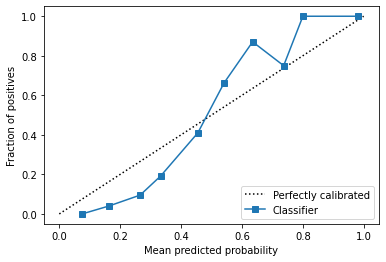

In [58]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, svm_pob_pred_col)
CalibrationDisplay.from_predictions(y_test, svm_pob_pred_col, n_bins=10)

### Your code is here




**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [59]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here




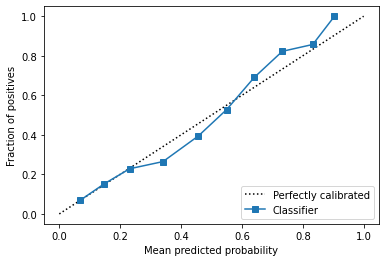

In [60]:
### Новая кривая
cal = CalibratedClassifierCV(pipe_svm, cv = 5, method='sigmoid')
cal.fit(X_train, y_train)
cal_prd = cal.predict_proba(X_test)[:,1]
### Your code is here
CalibrationDisplay.from_predictions(y_test, cal_prd, n_bins=10)



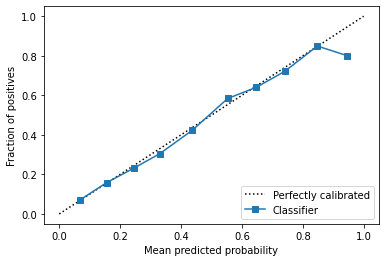

In [61]:
cal = CalibratedClassifierCV(pipe_svm, cv = 5, method='isotonic')
cal.fit(X_train, y_train)
cal_prd = cal.predict_proba(X_test)[:,1]
### Your code is here
CalibrationDisplay.from_predictions(y_test, cal_prd, n_bins=10)
